In [10]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [11]:
import numpy as np
import matplotlib.pyplot as plt

In [12]:
from os.path import isdir, join, isfile

In [13]:
import datetime
import pandas as pd
import seaborn as sns

In [14]:
dir_run1 = "../data/tests_performance/N128_OMP16_32nodes_2node"
dir_run2 = "../data/tests_performance/N128_OMP16_32nodes_bp4"

assert(isdir(dir_run1))
assert(isdir(dir_run2))

In [15]:
logfile_run1 = join(dir_run1, "delta.log")
logfile_run2 = join(dir_run2, "delta.log")

assert(isfile(logfile_run1))
assert(isfile(logfile_run2))

In [165]:
golden_ratio = 1.618



In [145]:
dframe_2node_pub = pd.DataFrame(columns = ["time_pub", "tidx"])
dframe_2node_con = pd.DataFrame(columns = ["time_con", "tidx"])

with open(logfile_run1, "r") as df:
    l0 = df.readline()
    splits = l0.split()
    # There is a , that needs to be removed
    fix_mus = splits[2].replace(",", ".", 1)
    fix_mus = fix_mus.replace(",", "")
    toff_run1 = datetime.datetime.strptime(splits[1] + " " + fix_mus, "%Y-%m-%d %H:%M:%S.%f") 

    for line in df:
        if "Published" in line:
            
            splits = line.split()
            fix_mus = splits[2].replace(",", ".", 1)
            fix_mus = fix_mus.replace(",", "")
            time_pub = datetime.datetime.strptime(splits[1] + " " + fix_mus, "%Y-%m-%d %H:%M:%S.%f") 
            tidx = int(splits[11])
            
            new_row = {"tidx": tidx, "time_pub": time_pub}

            dframe_2node_pub = dframe_2node_pub.append(new_row, ignore_index=True)
        
            
        elif "Consumed" in line:
            splits = line.split()
            fix_mus = splits[2].replace(",", ".", 1)
            fix_mus = fix_mus.replace(",", "")
            time_con = datetime.datetime.strptime(splits[1] + " " + fix_mus, "%Y-%m-%d %H:%M:%S.%f") 
            tidx = int(splits[12][5:])
            
            new_row = {"tidx": tidx, "time_con": time_con}
            dframe_2node_con = dframe_2node_con.append(new_row, ignore_index=True)    

In [146]:
dframe_2node = dframe_2node_pub.merge(dframe_2node_con, how="inner")
dframe_2node["delta"] = dframe_2node["time_con"] - dframe_2node["time_pub"]
dframe_2node["delta_secs"] = dframe_2node["delta"].apply(lambda x: x.seconds + x.microseconds * 1e-6)

In [147]:
dframe_file_pub = pd.DataFrame(columns = ["time_pub", "tidx"])
dframe_file_con = pd.DataFrame(columns = ["time_con", "tidx"])

with open(logfile_run2, "r") as df:
    l0 = df.readline()
    splits = l0.split()
    # There is a , that needs to be removed
    fix_mus = splits[2].replace(",", ".", 1)
    fix_mus = fix_mus.replace(",", "")
    toff_run2 = datetime.datetime.strptime(splits[1] + " " + fix_mus, "%Y-%m-%d %H:%M:%S.%f") 

    for line in df:
        if "Published" in line:
            
            splits = line.split()
            fix_mus = splits[2].replace(",", ".", 1)
            fix_mus = fix_mus.replace(",", "")
            time_pub = datetime.datetime.strptime(splits[1] + " " + fix_mus, "%Y-%m-%d %H:%M:%S.%f") 
            tidx = int(splits[11])
            
            new_row = {"tidx": tidx, "time_pub": time_pub}

            dframe_file_pub = dframe_file_pub.append(new_row, ignore_index=True)
        
            
        elif "Consumed" in line:
            splits = line.split()
            fix_mus = splits[2].replace(",", ".", 1)
            fix_mus = fix_mus.replace(",", "")
            time_con = datetime.datetime.strptime(splits[1] + " " + fix_mus, "%Y-%m-%d %H:%M:%S.%f") 
            tidx = int(splits[12][5:])
            
            new_row = {"tidx": tidx, "time_con": time_con}
            dframe_file_con = dframe_file_con.append(new_row, ignore_index=True)    

In [148]:
dframe_file = dframe_file_pub.merge(dframe_file_con, how="inner")
dframe_file["delta"] = dframe_file["time_con"] - dframe_file["time_pub"]
dframe_file["delta_secs"] = dframe_file["delta"].apply(lambda x: x.seconds + x.microseconds * 1e-6)

datetime.datetime(2020, 5, 22, 17, 43, 43, 782782)

time_pub      2020-05-22 17:43:58.534534
tidx                                   0
time_con      2020-05-22 17:43:58.534534
delta                    0 days 00:00:00
delta_secs                             0
Name: 0, dtype: object

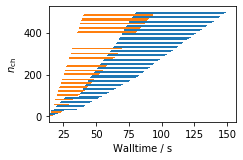

In [167]:
fig = plt.figure(figsize=(3.46, 3.46 / golden_ratio))
ax = fig.add_axes([0.2, 0.2, 0.75, 0.75])

for index, row in dframe_2node.iterrows():    
    offset = (row["time_pub"] - toff_run1)
    offset = offset.seconds + offset.microseconds * 1e-6
    ax.barh(y=row["tidx"], width=row["delta_secs"], left=offset, fc="C1", height=0.5)

for index, row in dframe_file.iterrows():    
    offset = (row["time_pub"] - toff_run2)
    offset = offset.seconds + offset.microseconds * 1e-6
    ax.barh(y=row["tidx"] + 0.5, width=row["delta_secs"], left=offset, fc="C0", height=0.5)
    
ax.set_xlabel(r"Walltime / s")
ax.set_ylabel(r"$n_\mathrm{ch}$")

fig.savefig("performance_time_subcon.png")

In [14]:
dframe["time_fft_secs"] = dframe["time_fft"].apply(lambda x: x.seconds + x.microseconds * 1e-6)

[Text(0, 0, '2-node'), Text(0, 0, 'file')]

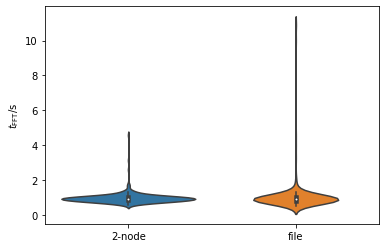

In [21]:


ax = sns.violinplot(x="mode", y="time_fft_secs", data=dframe)
ax.set(ylabel=r"$t_{\mathrm{FFT}} / \mathrm{s}$", xlabel="")
ax.set_xticklabels(["2-node", "file"])